Purpose of the notebook:
* load kmaps with different ROIs
* denoise them and shift correct them
* segment the domains

All of these in a dictionary fashion - at the end of the day, all of the kmaps are into one object.

In [23]:
import numpy as np
import lib.calc as c
import scipy.ndimage as nd

from skimage import filters, exposure, restoration, morphology, feature, measure
from matplotlib import pyplot as plt
from matplotlib import patches
from ipywidgets import interact, fixed
from silx.io import specfile as spec
from lib.kmap import *
from imp import reload

%matplotlib inline

Initialise filenames, scan numbers, etc.

In [2]:
# initialise varables
sf = '/users/zatterin/Documents/beam/hc3313/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150]


# select scans
for i,scan in enumerate(scan_list):
    scan_list[i] = scan - 1
# scan_list.append(94)
# scan_list.append(96)
voltagesd = dict()
for i in range(len(scan_list)):
    voltagesd[scan_list[i]] = voltages[i]

print(scan_list) 

[9, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 79, 84, 89]


Load the kmaps in a large dictionary, like `kmaps_all[<roi>][<scan_no>]`. A hack is needed because I originally wrote `read_kmap` to work differently.

In [3]:
# hack to get the desired dictionary (instead of scan --> rois)
kmaps_all = dict()
for roi in rois_103:
    kmaps_all[roi] = dict()
    for scan_no in scan_list:
        kmaps_all[roi][scan_no] = read_kmap(sf, scan_no, [roi], motors=False)[roi]

Now denoise the kmaps and create a `kmaps_denoised` dict that behaves like the previous one.

In [4]:
# perhaps there is a faster way to do this with kmaps_all.items()?
kmaps_denoised = dict()
for roi in kmaps_all:
    kmaps_denoised[roi] = dict()
    for scan in kmaps_all[roi]:
        kmaps_denoised[roi][scan] = denoise_kmap(kmaps_all[roi][scan])

Finally shift them and select the smallest window.

In [5]:
kmaps_shifted, shifts, winidx = shift_kmapsdict(kmaps_denoised, scan_list)

In [36]:
# display ROI being used if any
r1, r2 = 23, 110
r3, r4 = 190, 280

# Plot largest window
@interact(i=scan_list)
def plot(i=84):
    fig, axes = plt.subplots(1,4,figsize=(14,10))
    for index, ax in enumerate(axes):
        roi = 'roi'+str(index+1)
        img = kmaps_shifted[roi][i][winidx] - kmaps_shifted[roi][scan_list[0]][winidx] 
        ax.imshow(img)
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))
        ax.axis('off')
        ax.add_patch(patches.Rectangle((0,r1),
                    (img.shape[1]),
                    (r2-r1), fill=False, edgecolor='red',linewidth=2));
        ax.add_patch(patches.Rectangle((0,r3),
                    (img.shape[1]),
                    (r4-r3), fill=False, edgecolor='red',linewidth=2));

interactive(children=(Dropdown(description='i', index=13, options=(9, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 79, 84, 89), value=84), Output()), _dom_classes=('widget-interact',))

Have a look at the selected roi in needed:

In [38]:
# roi
@interact(i=scan_list)
def plot(i):
    fig, axes = plt.subplots(1,4,figsize=(14,10))
    for index, ax in enumerate(axes):
        roi = 'roi'+str(index+1)
        img = kmaps_shifted[roi][i][winidx][r1:r2,:]
        ax.imshow(img)
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))
        ax.axis('off')

interactive(children=(Dropdown(description='i', options=(9, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 79, 84, 89), value=9), Output()), _dom_classes=('widget-interact',))

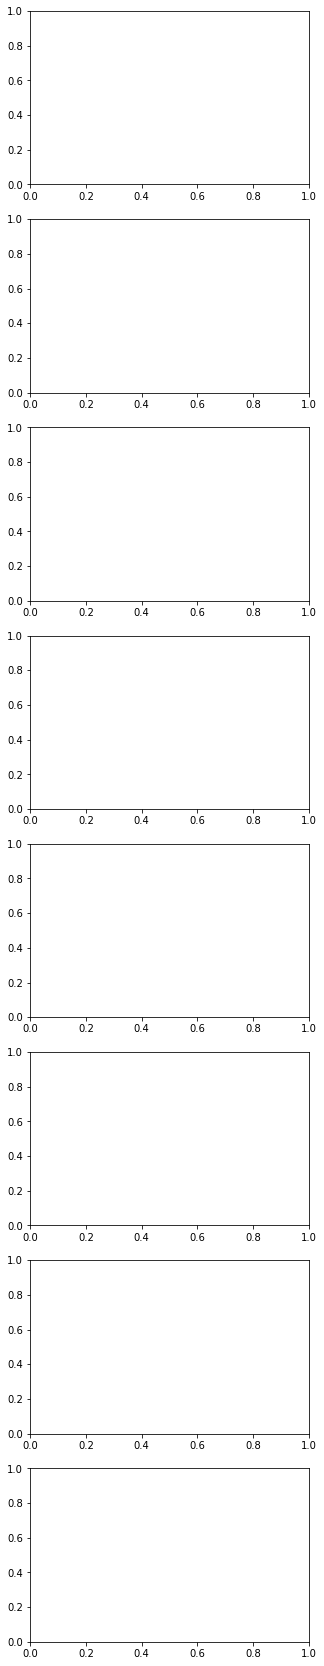

In [86]:
fig, ax = plt.subplots(8,1,figsize=(5,30))
for index, a in enumerate(ax):
    

Now select regions:

In [39]:
def threshold_kmap(kmap,t=0.15,disk_size=1,hval=20):
    # init
    se = morphology.selem.disk(disk_size)
    
    # compute rmax
    h = kmap.max() - kmap.max()/hval
    hmax = morphology.reconstruction(kmap-h, kmap, method='dilation', 
                                     selem=morphology.selem.disk(disk_size))
    rmax = kmap - hmax 
    
    # close gaps in rmax
    rmax_closed = morphology.closing(rmax, selem=morphology.selem.disk(disk_size))

    # totally arbitrary threshold!
    ots = filters.threshold_li(rmax_closed)
#     rmax_ts = rmax_closed > t*rmax_closed.max()
    rmax_ts = rmax_closed > ots
    rmax_tsm = morphology.binary_dilation(rmax_ts, selem=se) ^ morphology.binary_erosion(rmax_ts, selem=se)

    # mask it
    mask = np.ma.masked_where(rmax_tsm==0, rmax_tsm)
    
    return rmax_ts, mask

In [40]:
# select threshold level (see function above)
thresh = 0.1

# calc thresholds fro all images with voltage
kmaps_mask = dict()
for roi in kmaps_shifted:
    kmaps_mask[roi] = dict()
    for scan in kmaps_shifted[roi]:
#         kmaps_mask[roi][scan] = threshold_kmap(kmaps_shifted[roi][scan],t=thresh)
        kmaps_mask[roi][scan] = threshold_kmap(kmaps_shifted[roi][scan][r1:r2,:],t=thresh)

In [41]:
# select 5V and 70V thresholds
scan_5  = [key for key,value in voltagesd.items() if value == 5][0]
scan_70 = [key for key,value in voltagesd.items() if value == 70][0] 

In [84]:
# Plot 
@interact(i=scan_list, mask=['0V','70V'])
def plot(i,mask='0V'):
    fig, axes = plt.subplots(2,4,figsize=(15,10))
    
    for index, ax in enumerate(axes[0]):
        roi = 'roi'+str(index+1)
        ax.imshow(kmaps_shifted[roi][i][winidx][r1:r2,:])
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))
        ax.axis('off')

    for index, ax in enumerate(axes[1]):
        roi = 'roi'+str(index+1)
        ax.imshow(kmaps_mask[roi][i][0] ^ kmaps_mask[roi][scan_70][0])
#         ax.imshow(kmaps_shifted[roi][i][winidx][r1:r2,:])
#         if mask=='0V':
#             ax.imshow(kmaps_mask[roi][scan_5][1][winidx])
#         elif mask=='70V':
#             ax.imshow(kmaps_mask[roi][scan_70][1][winidx])            
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))
        ax.axis('off')

interactive(children=(Dropdown(description='i', options=(9, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 79, 84, 89), value=9), Dropdown(description='mask', options=('0V', '70V'), value='0V'), Output()), _dom_classes=('widget-interact',))

Finally make some calculations:

In [64]:
scan_list[7:]

[50, 56, 62, 68, 74, 79, 84, 89]

In [65]:
upvoltage, downvoltage = dict(), dict()
for roi in kmaps_mask:
    upvoltage[roi], downvoltage[roi] = [],[]
    for scan in scan_list[:8]: # up to 70V
        upvoltage[roi].append(np.count_nonzero(kmaps_mask[roi][scan][0] ^ kmaps_mask[roi][scan_5][0]))
    for scan in scan_list[7:]: # from 70 to -70V
        downvoltage[roi].append(np.count_nonzero(kmaps_mask[roi][scan][0] ^ kmaps_mask[roi][scan_70][0]))

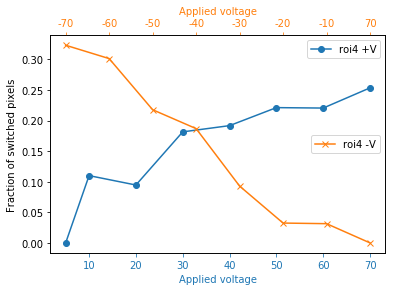

In [85]:
ROI = 'roi4'

fig, ax1 = plt.subplots()

ax1.plot(voltages[:8],[x/kmaps_mask[roi][scan_5][0].size for x in upvoltage[ROI]],marker='o', c='C0', label=ROI+' +V')
ax1.set_xlabel('Applied voltage',color='C0')
ax1.set_ylabel('Fraction of switched pixels')
ax1.tick_params('x', colors='C0')
ax1.legend(loc=0)

ax2 = ax1.twiny()
ax2.plot(range(7,-1,-1),[x/kmaps_mask[roi][scan_70][0].size for x in downvoltage[ROI]],marker='x', c='C1', label=ROI+' -V')
ax2.set_xticklabels([-70,-70,-60,-50,-40,-30,-20,-10,70]) # wtf??
ax2.set_xlabel('Applied voltage',color='C1')
ax2.tick_params('x', colors='C1')
ax2.legend(loc=5)

plt.show()